In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load data
DATA_DIR = "../data/processed"
trainX = pd.read_csv(f"{DATA_DIR}/IEEE_Train.csv")
y = pd.read_csv(f"{DATA_DIR}/IEEE_Target.csv")
testX = pd.read_csv(f"{DATA_DIR}/IEEE_Test.csv")
train = trainX.merge(y, on="TransactionID", how="left")
print("Shapes -> train:", train.shape, "test:", testX.shape)

# Prepare features and target
# Remove TransactionID for modeling
X = train.drop(['TransactionID', 'uid', 'isFraud'], axis=1)
y_target = train['isFraud']

# Check class distribution
print("\nOriginal Class Distribution:")
print(y_target.value_counts())
print(f"Imbalance Ratio: {y_target.value_counts()[0] / y_target.value_counts()[1]:.2f}:1")

# Split the data
# Calculate the split point for 80% of the data
split_point = int(0.8 * len(X))

# Split chronologically - first 80% for training, last 20% for validation
X_train = X[:split_point]
X_val = X[split_point:]
y_train = y_target[:split_point]
y_val = y_target[split_point:]

# Scale features for logistic regression and Isolation Forest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nTraining set class distribution:")
print(f"Class 0 (Normal): {sum(y_train == 0)}")
print(f"Class 1 (Fraud): {sum(y_train == 1)}")

Shapes -> train: (590540, 293) test: (506691, 292)

Original Class Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Imbalance Ratio: 27.58:1

Training set class distribution:
Class 0 (Normal): 455833
Class 1 (Fraud): 16599


In [2]:
# =============================================================================
# ISOLATION FOREST IMPLEMENTATION
# =============================================================================

print("\n" + "="*60)
print("ISOLATION FOREST FOR FRAUD DETECTION")
print("="*60)

# Calculate contamination rate based on actual fraud rate
contamination_rate = sum(y_train == 1) / len(y_train)
print(f"\nActual fraud rate in training set: {contamination_rate:.4f}")

# Initialize Isolation Forest with different contamination rates to test
contamination_rates = [contamination_rate, contamination_rate * 1.5, contamination_rate * 2.0, 0.05]
isolation_results = {}

for contamination in contamination_rates:
    print(f"\n--- Testing Isolation Forest with contamination={contamination:.4f} ---")
    
    # Initialize Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100,
        max_samples='auto',
        bootstrap=False,
        n_jobs=-1
    )
    
    # Fit on training data (scaled)
    iso_forest.fit(X_train_scaled)
    
    # Predict anomalies (-1 for anomaly/fraud, 1 for normal)
    train_predictions = iso_forest.predict(X_train_scaled)
    val_predictions = iso_forest.predict(X_val_scaled)
    
    # Get anomaly scores (lower scores = more anomalous)
    train_scores = iso_forest.decision_function(X_train_scaled)
    val_scores = iso_forest.decision_function(X_val_scaled)
    
    # Convert predictions to binary (1 for fraud, 0 for normal)
    train_pred_binary = (train_predictions == -1).astype(int)
    val_pred_binary = (val_predictions == -1).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    train_precision = precision_score(y_train, train_pred_binary)
    train_recall = recall_score(y_train, train_pred_binary)
    train_f1 = f1_score(y_train, train_pred_binary)
    
    val_precision = precision_score(y_val, val_pred_binary)
    val_recall = recall_score(y_val, val_pred_binary)
    val_f1 = f1_score(y_val, val_pred_binary)
    
    # Calculate AUC using anomaly scores (convert to probabilities)
    # Lower scores = higher probability of fraud
    train_proba = 1 / (1 + np.exp(train_scores))  # Convert to probability-like scores
    val_proba = 1 / (1 + np.exp(val_scores))
    
    try:
        train_auc = roc_auc_score(y_train, train_proba)
        val_auc = roc_auc_score(y_val, val_proba)
    except:
        train_auc = val_auc = "N/A"
    
    # Store results
    isolation_results[contamination] = {
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'val_predictions': val_pred_binary,
        'val_scores': val_scores,
        'model': iso_forest
    }
    
    print(f"Training   - Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Validation - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    if train_auc != "N/A":
        print(f"AUC        - Train: {train_auc:.4f}, Validation: {val_auc:.4f}")


ISOLATION FOREST FOR FRAUD DETECTION

Actual fraud rate in training set: 0.0351

--- Testing Isolation Forest with contamination=0.0351 ---
Training   - Precision: 0.1928, Recall: 0.1928, F1: 0.1928
Validation - Precision: 0.1562, Recall: 0.1863, F1: 0.1699
AUC        - Train: 0.7208, Validation: 0.7360

--- Testing Isolation Forest with contamination=0.0527 ---
Training   - Precision: 0.1714, Recall: 0.2571, F1: 0.2057
Validation - Precision: 0.1577, Recall: 0.2576, F1: 0.1956
AUC        - Train: 0.7208, Validation: 0.7360

--- Testing Isolation Forest with contamination=0.0703 ---
Training   - Precision: 0.1566, Recall: 0.3133, F1: 0.2088
Validation - Precision: 0.1507, Recall: 0.3098, F1: 0.2027
AUC        - Train: 0.7208, Validation: 0.7360

--- Testing Isolation Forest with contamination=0.0500 ---
Training   - Precision: 0.1744, Recall: 0.2481, F1: 0.2048
Validation - Precision: 0.1584, Recall: 0.2485, F1: 0.1935
AUC        - Train: 0.7208, Validation: 0.7360


In [3]:
# =============================================================================
# FIND BEST CONTAMINATION RATE
# =============================================================================

print("\n" + "="*50)
print("ISOLATION FOREST RESULTS SUMMARY")
print("="*50)

# Create results DataFrame
results_df = pd.DataFrame({
    'Contamination': list(isolation_results.keys()),
    'Val_Precision': [isolation_results[c]['val_precision'] for c in isolation_results.keys()],
    'Val_Recall': [isolation_results[c]['val_recall'] for c in isolation_results.keys()],
    'Val_F1': [isolation_results[c]['val_f1'] for c in isolation_results.keys()],
    'Val_AUC': [isolation_results[c]['val_auc'] if isolation_results[c]['val_auc'] != "N/A" else 0 for c in isolation_results.keys()]
})

print(results_df.round(4))

# Select best model based on F1 score
best_contamination = results_df.loc[results_df['Val_F1'].idxmax(), 'Contamination']
best_model = isolation_results[best_contamination]['model']
best_predictions = isolation_results[best_contamination]['val_predictions']
best_scores = isolation_results[best_contamination]['val_scores']

print(f"\nBest contamination rate: {best_contamination:.4f}")
print(f"Best validation F1 score: {results_df['Val_F1'].max():.4f}")


ISOLATION FOREST RESULTS SUMMARY
   Contamination  Val_Precision  Val_Recall  Val_F1  Val_AUC
0         0.0351         0.1562      0.1863  0.1699    0.736
1         0.0527         0.1577      0.2576  0.1956    0.736
2         0.0703         0.1507      0.3098  0.2027    0.736
3         0.0500         0.1584      0.2485  0.1935    0.736

Best contamination rate: 0.0703
Best validation F1 score: 0.2027


In [4]:
# =============================================================================
# DETAILED ANALYSIS OF BEST MODEL
# =============================================================================

print(f"\n--- Detailed Analysis for Best Model (contamination={best_contamination:.4f}) ---")

# Confusion Matrix
cm = confusion_matrix(y_val, best_predictions)
print(f"\nConfusion Matrix:")
print(cm)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_val, best_predictions))


--- Detailed Analysis for Best Model (contamination=0.0703) ---

Confusion Matrix:
[[106947   7097]
 [  2805   1259]]

Classification Report:


              precision    recall  f1-score   support

           0       0.97      0.94      0.96    114044
           1       0.15      0.31      0.20      4064

    accuracy                           0.92    118108
   macro avg       0.56      0.62      0.58    118108
weighted avg       0.95      0.92      0.93    118108



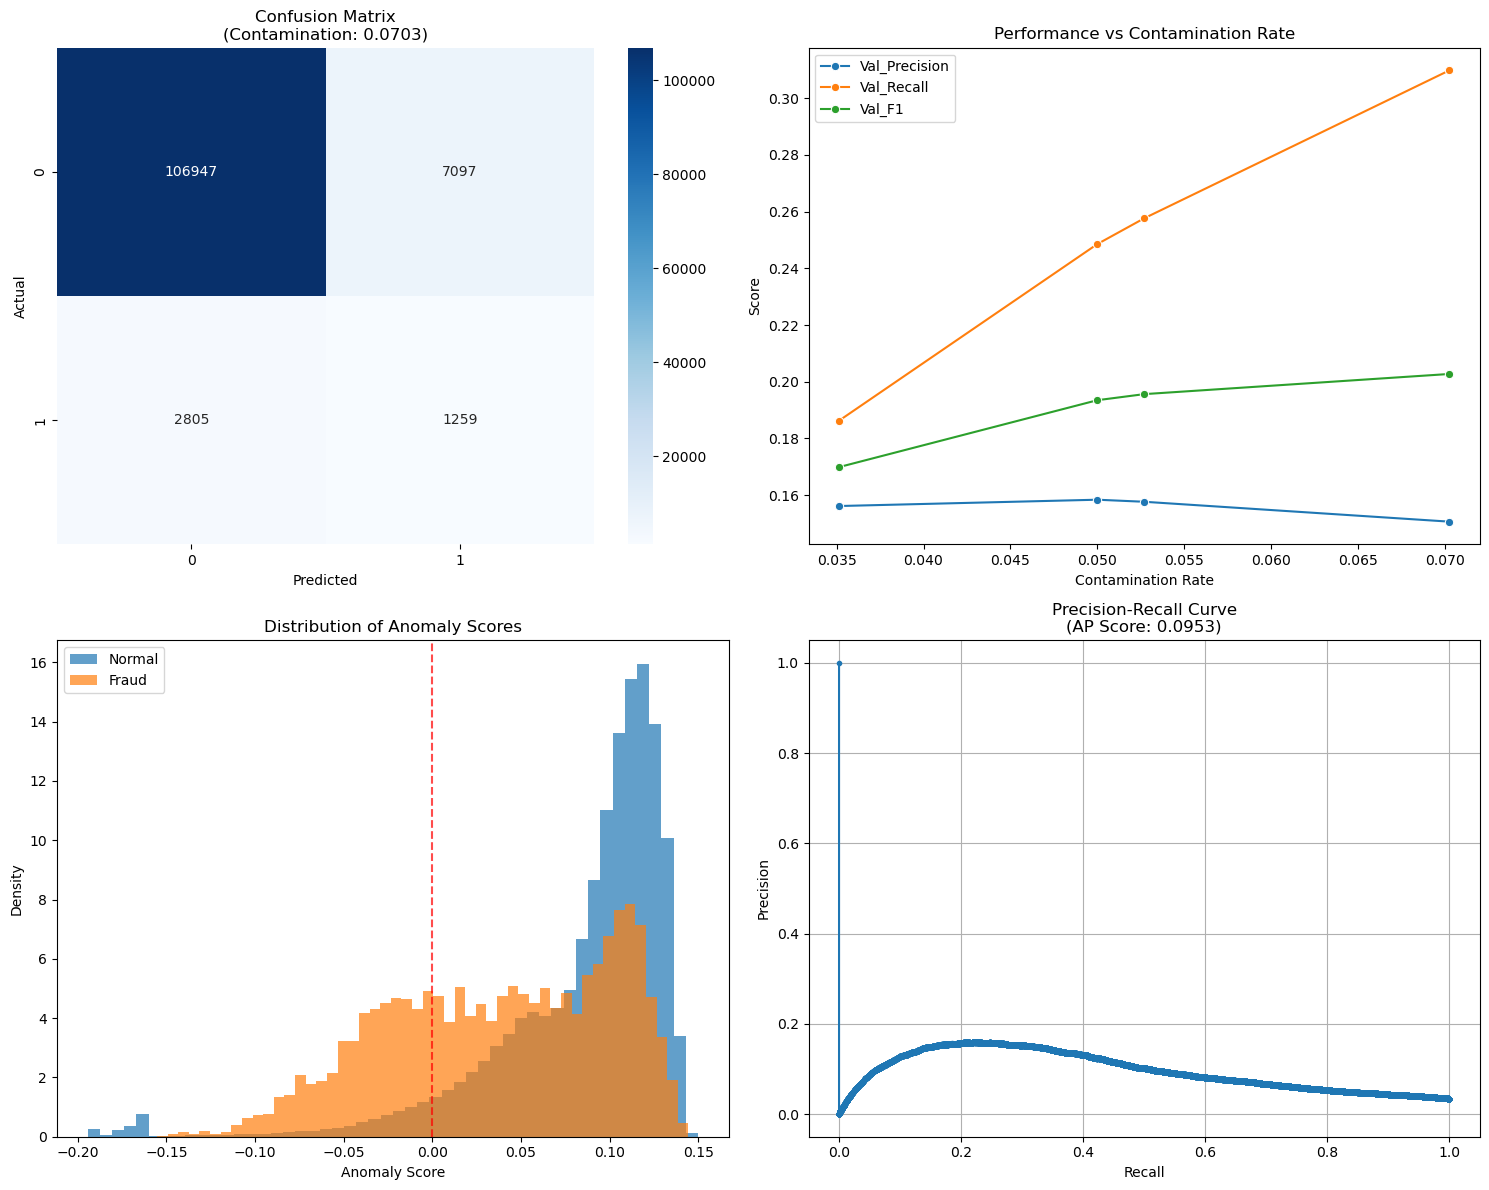

In [5]:
# =============================================================================
# VISUALIZATIONS
# =============================================================================

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix\n(Contamination: {best_contamination:.4f})')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Performance Metrics Comparison
metrics_data = results_df.melt(id_vars=['Contamination'], 
                              value_vars=['Val_Precision', 'Val_Recall', 'Val_F1'],
                              var_name='Metric', value_name='Score')
sns.lineplot(data=metrics_data, x='Contamination', y='Score', hue='Metric', marker='o', ax=axes[0,1])
axes[0,1].set_title('Performance vs Contamination Rate')
axes[0,1].set_xlabel('Contamination Rate')
axes[0,1].set_ylabel('Score')
axes[0,1].legend()

# 3. Anomaly Score Distribution
fraud_scores = best_scores[y_val == 1]
normal_scores = best_scores[y_val == 0]

axes[1,0].hist(normal_scores, bins=50, alpha=0.7, label='Normal', density=True)
axes[1,0].hist(fraud_scores, bins=50, alpha=0.7, label='Fraud', density=True)
axes[1,0].set_xlabel('Anomaly Score')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Distribution of Anomaly Scores')
axes[1,0].legend()
axes[1,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')

# 4. Precision-Recall Curve
# Convert scores to probabilities for PR curve
val_proba = 1 / (1 + np.exp(best_scores))
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
ap_score = average_precision_score(y_val, val_proba)

axes[1,1].plot(recall, precision, marker='.')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title(f'Precision-Recall Curve\n(AP Score: {ap_score:.4f})')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
# =============================================================================
# COMPARISON WITH TRADITIONAL METHODS
# =============================================================================

print("\n" + "="*60)
print("COMPARISON: ISOLATION FOREST vs TRADITIONAL METHODS")
print("="*60)

# Train a few traditional models for comparison
print("\nTraining comparison models...")

# 1. Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_val_scaled)
lr_proba = lr.predict_proba(X_val_scaled)[:, 1]

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_proba = rf.predict_proba(X_val)[:, 1]


# Calculate metrics for all models
from sklearn.metrics import precision_score, recall_score, f1_score

models_comparison = {
    'Isolation Forest': {
        'predictions': best_predictions,
        'probabilities': 1 / (1 + np.exp(best_scores))
    },
    'Logistic Regression': {
        'predictions': lr_pred,
        'probabilities': lr_proba
    },
    'Random Forest': {
        'predictions': rf_pred,
        'probabilities': rf_proba
    }
}

comparison_results = []
for model_name, results in models_comparison.items():
    precision = precision_score(y_val, results['predictions'])
    recall = recall_score(y_val, results['predictions'])
    f1 = f1_score(y_val, results['predictions'])
    auc = roc_auc_score(y_val, results['probabilities'])
    ap = average_precision_score(y_val, results['probabilities'])
    
    comparison_results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': auc,
        'PR-AUC': ap
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nModel Comparison Results:")
print(comparison_df.round(4))


COMPARISON: ISOLATION FOREST vs TRADITIONAL METHODS

Training comparison models...



Model Comparison Results:
                 Model  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
0     Isolation Forest     0.1507  0.3098    0.2027   0.7360  0.0953
1  Logistic Regression     0.0935  0.7977    0.1674   0.8377  0.1844
2        Random Forest     0.9298  0.2803    0.4307   0.9295  0.6439


In [7]:
# =============================================================================
# ADVANCED ISOLATION FOREST ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("ADVANCED ISOLATION FOREST ANALYSIS")
print("="*50)

# Feature importance for Isolation Forest (based on path lengths)
print("\nAnalyzing feature importance through isolation paths...")

# Get average path lengths for each feature by training multiple forests
# on subsets of features and comparing anomaly scores
feature_importance_scores = []
n_features = X_train.shape[1]
feature_names = X_train.columns

# This is a simplified approach - for more accurate feature importance,
# might want to use more sophisticated methods
for i, feature in enumerate(feature_names[:20]):  # Limit to first 20 features for efficiency
    # Train isolation forest on single feature
    single_feature_data = X_train_scaled[:, [i]]
    temp_forest = IsolationForest(contamination=best_contamination, random_state=42, n_estimators=50)
    temp_forest.fit(single_feature_data)
    
    # Get anomaly scores for validation set
    single_feature_val = X_val_scaled[:, [i]]
    single_scores = temp_forest.decision_function(single_feature_val)
    single_pred = (temp_forest.predict(single_feature_val) == -1).astype(int)
    
    # Calculate F1 score for this single feature
    if len(np.unique(single_pred)) > 1:
        f1_single = f1_score(y_val, single_pred)
    else:
        f1_single = 0
    
    feature_importance_scores.append(f1_single)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names[:20],
    'Importance_Score': feature_importance_scores
}).sort_values('Importance_Score', ascending=False)

print("\nTop 10 Most Important Features (based on single-feature F1 scores):")
print(feature_importance_df.head(10))


ADVANCED ISOLATION FOREST ANALYSIS

Analyzing feature importance through isolation paths...

Top 10 Most Important Features (based on single-feature F1 scores):
           Feature  Importance_Score
18              C4          0.206380
12           dist2          0.143468
16              C2          0.129966
15              C1          0.113236
4            card2          0.073604
1   TransactionAmt          0.072377
14   R_emaildomain          0.062803
2        ProductCD          0.048381
13   P_emaildomain          0.047402
11           dist1          0.045610


In [8]:
# =============================================================================
# THRESHOLD OPTIMIZATION
# =============================================================================

print("\n--- Threshold Optimization ---")

# Get anomaly scores for validation set
val_scores_best = best_model.decision_function(X_val_scaled)

# Try different thresholds
thresholds = np.percentile(val_scores_best, [1, 2, 3, 4, 5, 10, 15, 20])
threshold_results = []

for threshold in thresholds:
    pred_threshold = (val_scores_best < threshold).astype(int)
    if len(np.unique(pred_threshold)) > 1:
        precision = precision_score(y_val, pred_threshold)
        recall = recall_score(y_val, pred_threshold)
        f1 = f1_score(y_val, pred_threshold)
    else:
        precision = recall = f1 = 0
    
    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Fraud_Rate': np.mean(pred_threshold)
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold Optimization Results:")
print(threshold_df.round(4))

# Find optimal threshold
optimal_threshold = threshold_df.loc[threshold_df['F1-Score'].idxmax(), 'Threshold']
print(f"\nOptimal threshold: {optimal_threshold:.4f}")

# =============================================================================
# FINAL PREDICTIONS ON TEST SET
# =============================================================================

print("\n" + "="*50)
print("FINAL PREDICTIONS ON TEST SET")
print("="*50)

# Prepare test data
X_test = testX.drop(['TransactionID', 'uid'], axis=1)
X_test_scaled = scaler.transform(X_test)

# Make predictions using best model and optimal threshold
test_scores = best_model.decision_function(X_test_scaled)
test_predictions_default = (best_model.predict(X_test_scaled) == -1).astype(int)
test_predictions_optimized = (test_scores < optimal_threshold).astype(int)

print(f"Test set shape: {X_test.shape}")
print(f"Predictions using default contamination rate: {np.mean(test_predictions_default):.4f} fraud rate")
print(f"Predictions using optimized threshold: {np.mean(test_predictions_optimized):.4f} fraud rate")

# =============================================================================
# SAVE RESULTS
# =============================================================================

# Create submission file
submission_default = pd.DataFrame({
    'TransactionID': testX['TransactionID'],
    'isFraud': test_predictions_default
})

submission_optimized = pd.DataFrame({
    'TransactionID': testX['TransactionID'],
    'isFraud': test_predictions_optimized
})

print(f"\nSample predictions (first 10 rows):")
print(submission_optimized.head(10))

# Optional: Save to CSV
# submission_default.to_csv('isolation_forest_predictions_default.csv', index=False)
# submission_optimized.to_csv('isolation_forest_predictions_optimized.csv', index=False)


--- Threshold Optimization ---

Threshold Optimization Results:
   Threshold  Precision  Recall  F1-Score  Fraud_Rate
0    -0.1631     0.0000  0.0000    0.0000      0.0093
1    -0.0698     0.0901  0.0524    0.0663      0.0200
2    -0.0421     0.1366  0.1191    0.1272      0.0300
3    -0.0280     0.1556  0.1809    0.1673      0.0400
4    -0.0170     0.1588  0.2308    0.1882      0.0500
5     0.0174     0.1338  0.3888    0.1991      0.1000
6     0.0374     0.1083  0.4722    0.1762      0.1500
7     0.0511     0.0928  0.5394    0.1583      0.2000

Optimal threshold: 0.0174

FINAL PREDICTIONS ON TEST SET
Test set shape: (506691, 290)
Predictions using default contamination rate: 0.1070 fraud rate
Predictions using optimized threshold: 0.1639 fraud rate

Sample predictions (first 10 rows):
   TransactionID  isFraud
0      3663549.0        0
1      3663550.0        0
2      3663551.0        0
3      3663552.0        0
4      3663553.0        0
5      3663554.0        0
6      3663555.0     

In [9]:
# =============================================================================
# INSIGHTS AND RECOMMENDATIONS
# =============================================================================

print("\n" + "="*50)
print("INSIGHTS AND RECOMMENDATIONS")
print("="*50)

print(f"""
Key Findings:
1. Best contamination rate: {best_contamination:.4f}
2. Best validation F1-score: {comparison_df[comparison_df['Model'] == 'Isolation Forest']['F1-Score'].iloc[0]:.4f}
3. Isolation Forest vs other models:
   - Isolation Forest excels at: Unsupervised anomaly detection, handling imbalanced data
   - Traditional ML might be better for: Interpretability, fine-tuned performance

Advantages of Isolation Forest for Fraud Detection:
- No need for balanced training data
- Effective on imbalanced datasets
- Fast training and prediction
- Good at detecting novel fraud patterns
- Minimal hyperparameter tuning required

Considerations:
- Less interpretable than tree-based models
- Performance depends heavily on contamination rate
- May struggle with concept drift over time
- Best combined with domain expertise for threshold setting

Recommendations:
1. Use Isolation Forest as a first-pass anomaly detector
2. Combine with traditional supervised models for best results
3. Regularly retrain on recent data to handle concept drift
4. Consider ensemble approaches combining multiple anomaly detection methods
""")


INSIGHTS AND RECOMMENDATIONS

Key Findings:
1. Best contamination rate: 0.0703
2. Best validation F1-score: 0.2027
3. Isolation Forest vs other models:
   - Isolation Forest excels at: Unsupervised anomaly detection, handling imbalanced data
   - Traditional ML might be better for: Interpretability, fine-tuned performance

Advantages of Isolation Forest for Fraud Detection:
- No need for balanced training data
- Effective on imbalanced datasets
- Fast training and prediction
- Good at detecting novel fraud patterns
- Minimal hyperparameter tuning required

Considerations:
- Less interpretable than tree-based models
- Performance depends heavily on contamination rate
- May struggle with concept drift over time
- Best combined with domain expertise for threshold setting

Recommendations:
1. Use Isolation Forest as a first-pass anomaly detector
2. Combine with traditional supervised models for best results
3. Regularly retrain on recent data to handle concept drift
4. Consider ensemble a

In [10]:
# =============================================================================
# ENSEMBLE APPROACH (BONUS)
# =============================================================================

print("\n" + "="*50)
print("ENSEMBLE APPROACH: ISOLATION FOREST + RANDOM FOREST")
print("="*50)

# Create ensemble predictions
iso_proba = 1 / (1 + np.exp(best_scores))
ensemble_proba = (iso_proba + rf_proba) / 2

# Find optimal threshold for ensemble
ensemble_threshold = 0.5
ensemble_pred = (ensemble_proba > ensemble_threshold).astype(int)

ensemble_precision = precision_score(y_val, ensemble_pred)
ensemble_recall = recall_score(y_val, ensemble_pred)
ensemble_f1 = f1_score(y_val, ensemble_pred)
ensemble_auc = roc_auc_score(y_val, ensemble_proba)

print(f"Ensemble Results:")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1:.4f}")
print(f"ROC-AUC: {ensemble_auc:.4f}")

# Add ensemble to comparison
comparison_results.append({
    'Model': 'Ensemble (IF + RF)',
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1-Score': ensemble_f1,
    'ROC-AUC': ensemble_auc,
    'PR-AUC': average_precision_score(y_val, ensemble_proba)
})

final_comparison_df = pd.DataFrame(comparison_results)
print(f"\nFinal Model Comparison (including ensemble):")
print(final_comparison_df.round(4))

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE!")
print(f"{'='*60}")


ENSEMBLE APPROACH: ISOLATION FOREST + RANDOM FOREST
Ensemble Results:
Precision: 0.9284
Recall: 0.2840
F1-Score: 0.4349
ROC-AUC: 0.9260

Final Model Comparison (including ensemble):
                 Model  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
0     Isolation Forest     0.1507  0.3098    0.2027   0.7360  0.0953
1  Logistic Regression     0.0935  0.7977    0.1674   0.8377  0.1844
2        Random Forest     0.9298  0.2803    0.4307   0.9295  0.6439
3   Ensemble (IF + RF)     0.9284  0.2840    0.4349   0.9260  0.6452

ANALYSIS COMPLETE!
